<a href="https://colab.research.google.com/github/2019ht12169/Thesis/blob/main/simpleBertImpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
! python3.7 -m pip install tensorflow-gpu==1.15.0
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt 

In [11]:
# check out what the data looks like before you get started
# look at the training data set
train_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_train.csv',index_col=None)
train_df=train_df.drop(['review_date'],axis='columns')
train_df = train_df.dropna().reset_index(drop=True)

# look at the test data set
test_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_test.csv',index_col=None)
test_df = test_df.dropna().reset_index(drop=True)

In [ ]:
train_df['label'].astype(int)
test_df['label'].astype(int)

Text(0, 0.5, 'Labels')

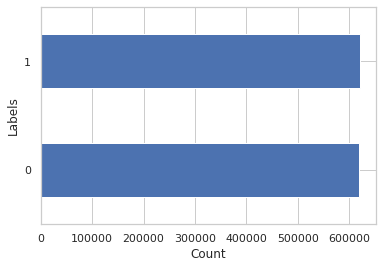

In [14]:
import seaborn as sns

# Print the Distribution of Labels
sns.set_theme(style="whitegrid")
ax = train_df['label'].value_counts(sort=False).plot(kind='barh', color='b')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

In [15]:
bert_df = pd.DataFrame({
    'id': range(len(train_df)),
    'label': train_df['label'],
    'alpha': ['q']*train_df.shape[0],
    'text': train_df['text'].replace(r'\n', ' ', regex=True)
})

train_bert_df, dev_bert_df = train_test_split(bert_df, test_size=0.2)

In [16]:
print(len(train_bert_df))
print(len(dev_bert_df))

992095
248024


In [17]:
test_bert_df = pd.DataFrame({
    'id': range(len(test_df)),
    'text': test_df['text'].replace(r'\n', ' ', regex=True),
    'review_date': test_df['review_date']
})

In [18]:
train_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/train.tsv', sep='\t', index=False, header=False)
dev_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/dev.tsv', sep='\t', index=False, header=False)
test_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/test.tsv', sep='\t', index=False, header=True)

In [ ]:
! python /content/gdrive/MyDrive/projects/bert/run_classifier.py --task_name=cola --do_train=true --do_eval=true --data_dir=/content/gdrive/MyDrive/projects/data/Data-BERT --vocab_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/vocab.txt --bert_config_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_config.json --init_checkpoint=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_model.ckpt --max_seq_length=128 --train_batch_size=32 --learning_rate=2e-5 --num_train_epochs=3.0 --output_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/model_output --do_lower_case=true


In [ ]:
!python /content/gdrive/MyDrive/projects/bert/run_classifier.py --task_name=cola --do_predict=true --data_dir=/content/gdrive/MyDrive/projects/data/Data-BERT --vocab_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/vocab.txt --bert_config_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_config.json --init_checkpoint=/content/gdrive/MyDrive/projects/model_output_latest/model.ckpt-43736 --max_seq_length=128 --output_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/model_output_latest/

In [32]:
#read the original test data for the text and id
df_test = pd.read_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/test.tsv', sep='\t',index_col=None)

#read the results data for the probabilities
df_result = pd.read_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/model_output_latest/test_results.tsv', sep='\t',names=['neg', 'pos'])


In [37]:

test_df.loc[test_df['label'] == 1, 'actual_label'] = 'pos'
test_df.loc[test_df['label'] == 0, 'actual_label'] = 'neg'

#create a new dataframe
df_map_result = pd.DataFrame({
    'pred_label': df_result.idxmax(axis=1),
    'actual_label': test_df['actual_label'],
    'review_date': df_test['review_date'],
    'text': df_test['text']})

#view sample rows of the newly created dataframe
df_map_result.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/mapped_results.csv',header=True,index=False)
df_map_result.head()

,pred_label,actual_label,review_date,text
0,pos,pos,2015-01-07,five stars works well for my house where i con...
1,pos,pos,2011-05-07,great for the price! i bought these to plug in...
2,pos,pos,2014-09-26,great results this little antenna works very w...
3,pos,pos,2011-12-23,great sound quality this set of headphones has...
4,pos,pos,2013-10-29,everything i wanted in my new music device thi...


In [41]:
def evaluate_results(mapped_df):
    y_true = mapped_df['actual_label']
    y_pred = mapped_df['pred_label']
    target_names = ['neg','pos']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = score(y_pred, y_true, average='macro')
    return model_score

              precision    recall  f1-score        support
neg            0.928473  0.596902  0.726651  155012.000000
pos            0.703017  0.954025  0.809510  155042.000000
accuracy       0.775481  0.775481  0.775481       0.775481
macro avg      0.815745  0.775464  0.768080  310054.000000
weighted avg   0.815734  0.775481  0.768084  310054.000000


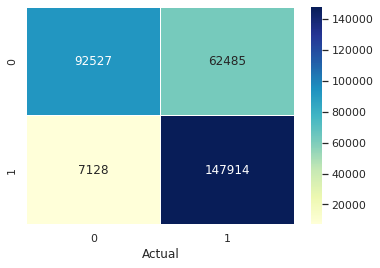

In [44]:
model_score = evaluate_results(df_map_result)
performance_df = pd.DataFrame().append({'model_name': 'BERT classifier', 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

   f1_score       model_name  precision   recall
0  0.775464  BERT classifier   0.815745  0.76808


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

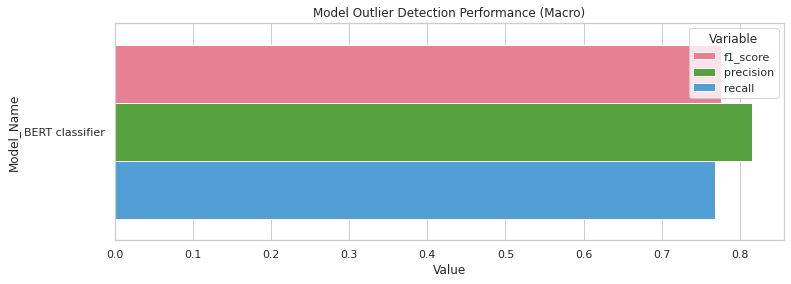

In [45]:
print(performance_df)

fig, ax = plt.subplots(figsize=(12, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='husl',  linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')

In [21]:
# grouping for data visualization [grouping by label]
score = df_map_result['text'].groupby(df_map_result['pred_label'])
score.count()

pred_label
neg     99655
pos    210399
Name: text, dtype: int64

In [22]:
# grouping for data visualization [grouping by review date's year]
df_map_result['review_date'] = pd.to_datetime(df_map_result['review_date'])
score1 = df_map_result['text'].groupby(df_map_result['review_date'].dt.strftime('%Y'))
score1.count()

review_date
1999       43
2000      445
2001      623
2002      842
2003     1105
2004     1468
2005     2264
2006     3259
2007     6214
2008     7284
2009     9457
2010    12985
2011    19533
2012    27512
2013    55523
2014    82481
2015    79016
Name: text, dtype: int64

In [ ]:
92527 - true negative
147914 - true positive
62485 - false negative
7128 - false positive

In [47]:
(92527+147914)/(92527+147914+62485+7128)

0.7754810452372812

In [183]:
147914/(147914+7128)

0.9540253608699578

In [48]:
147914/(147914+62485)

0.7030166493186755

In [49]:
(2*0.954*0.703)/(0.954+0.703)

0.8094894387447193